In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import random 

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, mean_absolute_error

import xgboost
import numerapi
NAPI = numerapi.NumerAPI(verbosity="info")
import random as rn
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

from helpers.utils import *
from helpers.xgboost_feval import *
from models.burningcrusade.data_preparation import prepare_data

In [2]:
DIR = "/Users/brianbroeking/projects/numerai/data"
download_current_data(DIR)
train_static, val_static, tournament_static = load_data(DIR, reduce_memory=True)

You already have the newest data! Current round is: 261
Loading the data


In [3]:
train_with_group = get_group_stats(train_static)
tournament_with_group = get_group_stats(tournament_static)

In [4]:
TARGET_NAME = f"target"
PREDICTION_NAME = f"prediction"
feature_names = generate_features_list(train_static)

In [5]:
ft_corr_list = random.sample(feature_names, 31)
train, tournament = generate_polynomial_features(ft_corr_list, train_with_group, tournament_with_group)

In [6]:
X_train, y_train = clean_for_xgboost(train)
dtrain = xgboost.DMatrix(X_train, y_train)

X_tournament, y_tournament = clean_for_xgboost(tournament)
dtournament = xgboost.DMatrix(X_tournament, y_tournament)

In [41]:
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = ar1(x)
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return np.mean(x)/(np.std(x, ddof=1)*autocorr_penalty(x))

def era_boost_train(X, y, era_col, proportion=0.5,
                    trees_per_step=10, num_iters=200,
                    one_shot=False, tree_method='hist',
                    test_model=None, note=None):
    print(f"\n#### Era boost train with proportion {proportion:0.3f} ####\n")
    if note is not None:
        print(note)
    if one_shot:
        trees_per_step = trees_per_step * num_iters
        num_iters=1

    if test_model is None:
        print(f"Train {num_iters} iterations")
        print(f"Train {trees_per_step} rounds per iteration")
    else:
        print("Testing model performance")
    features = X.columns
    new_df = X.copy()
    new_df["target"] = y
    new_df["era"] = era_col
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': 25,
        'learning_rate': 0.05,
        'colsample_bytree': 0.1,
        'gamma': 0.1, # trained at gammas 1,2,.75,.3
        'alpha': 7,
        'lambda': 9,
        'max_depth': 7,
        'min_child_weight': 16
    }
    for i in range(num_iters):
        print(f"\nIteration {i+1}:\n")
        if test_model is None:
            if i==0:
                model = xgboost.XGBRegressor(**params,
                                             n_jobs=-1,
                                             tree_method=tree_method)
                model.fit(X, y)
            else:
                model.n_estimators += trees_per_step
                booster = model.get_booster()
                print("fitting on worst eras")
                model.fit(worst_df[features], worst_df["target"], xgb_model=booster)
        else:
            if i == 0:
                model = test_model
            else:
                model.n_estimators += trees_per_step
                booster = model.get_booster()
                print("fitting on worst eras")
                model.fit(worst_df[features], worst_df["target"], xgb_model=booster)
        # score each era
        print("predicting on train")
        preds = model.predict(X)
        new_df["pred"] = preds
        era_scores = pd.Series(index=new_df["era"].unique())
        print("getting per era scores")
        for era in new_df["era"].unique():
            era_df = new_df[new_df["era"] == era]
            print(spearmanr(era_df["pred"], era_df["target"])[0])
            era_scores[era] = spearmanr(era_df["pred"], era_df["target"])[0]
        era_scores.sort_values(inplace=True)
        worst_eras = era_scores[era_scores <= era_scores.quantile(proportion)].index
        print(list(worst_eras))
        worst_df = new_df[new_df["era"].isin(worst_eras)]
        era_scores.sort_index(inplace=True)
        era_scores.plot(kind="bar")
        print("performance over time")
        plt.show()
        print("autocorrelation")
        print(ar1(era_scores))
#         if (ar1(era_scores)) < 0.1:
#             return model
        print("mean correlation")
        print(np.mean(era_scores))
        print("sharpe")
        print(np.mean(era_scores)/np.std(era_scores))
        print("smart sharpe")
        print(smart_sharpe(era_scores))
    return model


#### Era boost train with proportion 1.000 ####

Train 40 iterations
Train 10 rounds per iteration

Iteration 1:

predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.05639460063593336
0.07232158453130186
0.06000325424069687
0.1280187712468971
0.09451250791309265
0.05969541491050693
0.03820370218892007
0.08839757196130331
0.03502497460129414
0.08204931276294913
0.07117591818075188
0.0572859811144344
0.04533670721451736
0.0549274029587488
0.04489891585122432
0.09138141074833321
0.04109083557953029
0.039437187536468646
0.04599348535030094
0.07268614666792367
0.048270370580724246
0.08552765502820953
0.08576040010174561
0.07104644230531151
0.053829752700108854
0.04343692369314005
0.028778319929322425
0.0354931842211756
0.06899928550524355
0.11093513674391285
0.026088099677425727
0.03515084000494974
0.022472792352785428
0.03509660227443778
0.05696143221448264
0.09130307464927757
0.04652687058917353
0.08077656185438009
0.10107388964393059
0.029839191954945502
-0.004960000212107066
0.035014059087340454
0.0484249938655438
0.08200048385954392
0.08775040074936516
0.02207219787424172
0.0744679198041258
0.08784679753267569
0.01984032173

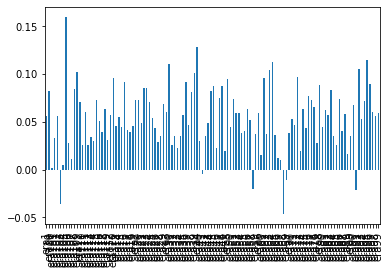

autocorrelation
0.07635285111232004
mean correlation
0.053271736157914445
sharpe
1.6141798752106813
smart sharpe
1.4900080986671906

Iteration 2:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.07046132815086252
0.08027579160933322
0.06308175197245225
0.13317449575456752
0.10990007340776792
0.06770646136831002
0.04834440581207114
0.10259181631357911
0.03686860350256128
0.08141231341473172
0.0812389013878367
0.0812140084723196
0.05770498054357357
0.05656061489618035
0.059970677936665114
0.10467623395435706
0.04867258559249062
0.043612195376198724
0.05405224457726827
0.08463999856675833
0.04972566596747199
0.0932605965656584
0.10394946035729775
0.0701595989704596
0.06705693867022045
0.04246905168852603
0.03170999217563522
0.05280267775654893
0.08153358709361072
0.11686094422254291
0.037716539308811435
0.048498294896782215
0.02473343597225063
0.04412642061004213
0.05772866566715657
0.10280286496581122
0.059118362907734215
0.09388815834191686
0.09634961193993298
0.04305668194519683
-0.005671402821640888
0.0435596162627618
0.05400673810861004
0.09577042703336269
0.09094759093730007
0.03205206792133992
0.09005779660831276
0.09715857244291817
0.0291375237416

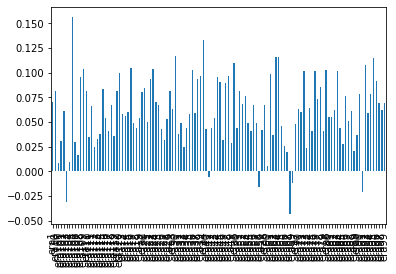

autocorrelation
0.08023438348196009
mean correlation
0.05999026312719439
sharpe
1.7539052018584356
smart sharpe
1.6127275942213721

Iteration 3:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.07869399593431402
0.07521791567286418
0.06819430471938939
0.13643838228497798
0.11105723304430644
0.07359553370740358
0.051143187157785396
0.10664758690560619
0.039465124357069545
0.08393523949882674
0.08648346805712809
0.08934157641351632
0.07385858309457012
0.06199094274056659
0.06446871130616671
0.11164393430956282
0.05218099841193029
0.04350672962193154
0.05218540616878046
0.08336771616800404
0.04821835826533197
0.09861151906156801
0.111728359647319
0.06867043360847568
0.07243292907220418
0.04424619017693239
0.03499644105843832
0.05555255715025589
0.08076217414191038
0.12249773661452786
0.04327999466602301
0.05188454679455808
0.028758029150566425
0.04350739991299585
0.059047207869120974
0.10889380230791303
0.06475208813352694
0.09807472109166679
0.09585066586548945
0.04982037339240439
-0.004514385455645098
0.05100933931592274
0.06096427710550009
0.10170278362871513
0.09528053218105424
0.03308939604043796
0.09103308209187023
0.10055028245068258
0.03056715969

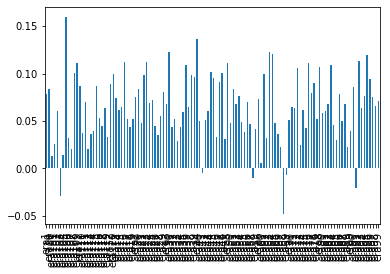

autocorrelation
0.0870760943592508
mean correlation
0.06291588361727299
sharpe
1.7916396187325456
smart sharpe
1.6362083749567014

Iteration 4:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.0828582673822871
0.07466636729721825
0.06980375397312973
0.14098443114778877
0.11638231460878064
0.07639472597953334
0.05736527809249069
0.10982938283422164
0.04112946212651901
0.08766449781187695
0.08692711848157758
0.09308612845076905
0.07740218420296609
0.06653910972934476
0.0638083513815864
0.11208769650413185
0.05441356291887391
0.04439186371792279
0.05294303794272531
0.08454281189720553
0.04884542148916826
0.10059523594312407
0.11484150458457736
0.07616864652837482
0.07255897067245448
0.04743994179645983
0.03782024011959764
0.05717203484882853
0.08297142824101465
0.12430585229075018
0.0488113248429182
0.05478898826431611
0.032205331872074534
0.04546766172223175
0.05854293035222926
0.11195408549678511
0.06670204609975679
0.09804467280321685
0.09743713961385689
0.05153505291456023
-0.0012587142160138862
0.053256728645427076
0.06706199415423403
0.1040836226902193
0.09496826960917787
0.03472606065377491
0.09264408236250073
0.10319153982860742
0.03513729678622

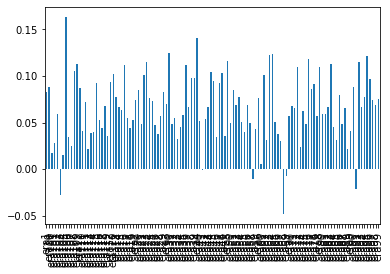

autocorrelation
0.08528115071361009
mean correlation
0.06498813997473882
sharpe
1.8257566744770821
smart sharpe
1.6703580158421385

Iteration 5:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.08759119558286929
0.07461551190514228
0.07378490200933578
0.13915931911280977
0.11802571059507577
0.07840453380090959
0.06334251134139879
0.11106746970918491
0.04103130376026988
0.09150628088954992
0.08933210075569321
0.09245266382075033
0.07732155810531337
0.06758857887052332
0.06458017558130036
0.11147356794998604
0.055476674290314006
0.04455485279714718
0.05476393201957003
0.08583836929331122
0.05083921560054742
0.10286000904720863
0.11495534443388912
0.07959934066533568
0.07045723672883722
0.04869309589835042
0.04058300803259709
0.05720968511081469
0.08441497118172155
0.1267785299415704
0.051470523760172034
0.05464891394532291
0.035090161178121415
0.048298879741108074
0.06007001369689722
0.11275869075439697
0.06847762437401927
0.09976416279740205
0.09860182745917223
0.053384346210046354
0.0017883347297870669
0.05234782340858078
0.06854995139817126
0.1061002100985683
0.0953058780182778
0.03673954464764804
0.09502592641380832
0.10522632049686817
0.03617594329

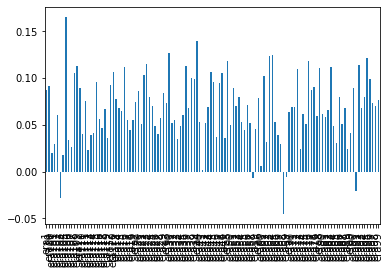

autocorrelation
0.08521174915036417
mean correlation
0.06636858250158448
sharpe
1.8741341925316906
smart sharpe
1.7147367552751889

Iteration 6:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.09186919085128874
0.07533792968254185
0.07461726467810478
0.1385368621910576
0.11850654533138666
0.08234628445577125
0.06437462286866391
0.11377525345248417
0.047012367789734465
0.09698894725615435
0.09141842567915334
0.09513676155721784
0.07938180275794349
0.06735397158818565
0.06393971047422553
0.11156106287632821
0.05786190978998185
0.04842334280869008
0.05513839643355135
0.08491768451075912
0.05257446738180284
0.10201007311472227
0.11871346562404157
0.08355005940492945
0.07396168538576604
0.05023194528190401
0.04226301255459023
0.05660801894521339
0.08545024717837411
0.1271004327285849
0.05491989875021222
0.05947927426597554
0.03518492340393313
0.04582657213152877
0.06151103361311608
0.11536330113504306
0.06890979519879732
0.10355825401070809
0.09904116842416975
0.055366992248430225
0.0068134175015965685
0.05418682641708368
0.07128169563823983
0.10730587227621108
0.09252626610253238
0.03837957747919155
0.09591251244089717
0.10570657557892979
0.0392131943828

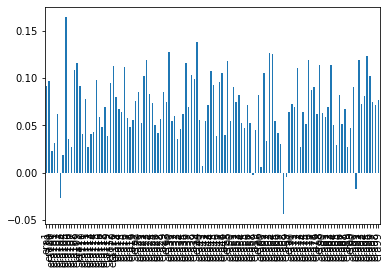

autocorrelation
0.08938318664330112
mean correlation
0.06815642889736301
sharpe
1.9261328490240344
smart sharpe
1.7549830762284928

Iteration 7:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.09184867300741077
0.07541035281093338
0.0761537467024267
0.13799367874713
0.1169155490219414
0.08843515669636172
0.06729721717437574
0.11238431154566735
0.05147252700015051
0.10049716758741338
0.09529890384209401
0.09463736621632536
0.08331881084885533
0.06777270120352095
0.06490338155893047
0.11274795206008596
0.05954934590063954
0.0501843339901731
0.057727522837973055
0.08853937785966766
0.05724258017401157
0.10572146753099468
0.12013327998665017
0.08519855790855024
0.07543411636315447
0.0523493945315297
0.04701416701007222
0.05666877239851805
0.08559144092565826
0.12887115695809506
0.05817928990450271
0.06337125041540113
0.034336999576927235
0.04721081633644046
0.062014633464134765
0.11650510982732733
0.07113116842580741
0.10459182774559202
0.09991290396063812
0.056732611374812045
0.008688147740918015
0.05671190063040779
0.0737134108107773
0.1099871406421614
0.09490833774837294
0.04094375722234646
0.09870105096730049
0.10593930948983382
0.043487050229470144


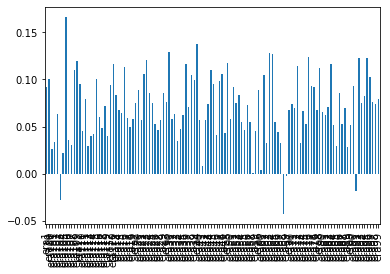

autocorrelation
0.0880184367032825
mean correlation
0.07007339220689289
sharpe
1.9802471922282932
smart sharpe
1.8067515664253022

Iteration 8:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.09856680802952532
0.07422216161817961
0.07598331033672523
0.13674781850452133
0.11800494377316446
0.08971416658159598
0.07139643798091798
0.11314501828869927
0.04847360910034985
0.10352225147787973
0.09772657837060487
0.0977548966741088
0.08537056465297008
0.06976440251594343
0.06838435941142423
0.11412967438631842
0.06057420577671933
0.049621609291490724
0.057598568554037936
0.09023210012091425
0.06049515210136217
0.10756259150403095
0.12303617548860885
0.0867155921904622
0.07882819484340764
0.05399227633921614
0.05194565117212763
0.05893039585700807
0.08529089508627682
0.13237054247280705
0.061706907513272145
0.06381671021116207
0.03740743905806305
0.047435666974942566
0.06291316546590328
0.11954124711332247
0.07391631170017116
0.10684765385094712
0.10066272940682697
0.06041378964393733
0.015189286739686454
0.0578874482539179
0.07889391200414222
0.10958968930054176
0.09694985707520862
0.044439698224213044
0.10197725894837821
0.10651494705661199
0.046983926918

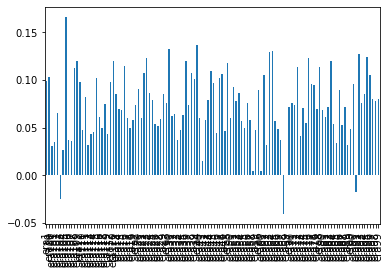

autocorrelation
0.08728235145698802
mean correlation
0.07228071191855087
sharpe
2.0631175847045684
smart sharpe
1.8837464072146515

Iteration 9:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.1001796683920701
0.07623399342027894
0.07707069224608155
0.1372712252576372
0.1214170033766329
0.09133207270567008
0.07313377486457348
0.11373179411243516
0.050785918556575854
0.10521365365740655
0.09761258144646077
0.099450413645526
0.08954335979772872
0.07201555665923672
0.07239841609744826
0.11479538864617415
0.06189375942750731
0.052445644102839764
0.0570071957829937
0.09243280757784327
0.06064400057252818
0.10870983986646333
0.12557932323368245
0.08945077939267408
0.08001257613427994
0.05569182742951099
0.05515838399770747
0.06043264895403547
0.08634404524376305
0.13150488187470677
0.06334187362458764
0.06393156982530293
0.03999194608985545
0.04938507654641669
0.06459915081175802
0.11928677395275088
0.07754469342345181
0.10681041989027276
0.10003326779622658
0.062457678625794655
0.018198637758695138
0.058998045568534684
0.08183434860563836
0.11116882765491035
0.09871842837966045
0.0458612181540409
0.10245620802386007
0.1069400780180374
0.049320409028764695

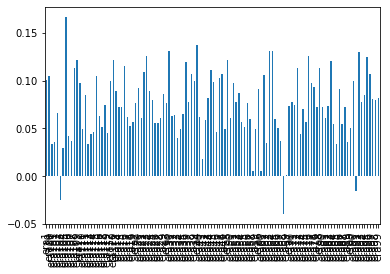

autocorrelation
0.09278605222919932
mean correlation
0.07380915066908897
sharpe
2.113530172505055
smart sharpe
1.9191882761733676

Iteration 10:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.10152720301294942
0.07829617665517433
0.07688750495927961
0.1385923277706502
0.1218217104800607
0.09193872997521674
0.07527741850273939
0.11483362536384016
0.05021025112116079
0.10692644291625658
0.09838217119578241
0.10040346648296876
0.0898264806781395
0.07401883516243307
0.0756082271954804
0.11573847982304676
0.06251432571538275
0.05376980194161667
0.05978240237573738
0.0952530732324
0.06260352829900469
0.11040274716594944
0.1270983489907446
0.09168553358759811
0.08174264764384677
0.05572536846189554
0.056433476872075776
0.06061382466068923
0.08571148295976833
0.13292600857388964
0.06603703177028603
0.06553938548622437
0.04185466661029034
0.049078850602839695
0.06498245709076257
0.121893348469926
0.07844973718594486
0.10768058598463906
0.10224388352901893
0.061691978925086655
0.017865782363914888
0.06111640729473455
0.08297455978745003
0.1146333952715137
0.09804201908886168
0.04548293441867819
0.102546880034566
0.10739346233116383
0.04956406078693631
0.06171

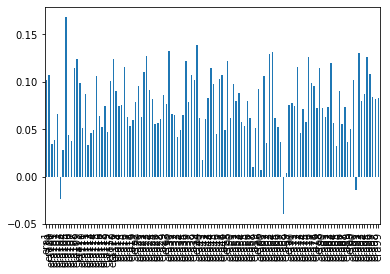

autocorrelation
0.09555509192345243
mean correlation
0.07499575797461049
sharpe
2.1446117052701044
smart sharpe
1.9420247964362853

Iteration 11:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.10641916314049468
0.08168635684938769
0.07690559715920671
0.13967685820243542
0.12303153963028883
0.093538697995498
0.07792648101721739
0.11729350092320907
0.05218366259434044
0.10876146098506462
0.10269030701736752
0.10031721924593928
0.09069401811405377
0.07546467382303113
0.07810587962562361
0.11427055432739985
0.06261087359000804
0.05337431936066764
0.06315045958666403
0.09629858781972178
0.06601142094671332
0.11284121483103733
0.13128411419881253
0.09419309504323338
0.08477321257278835
0.05614854458773404
0.05931336347642182
0.06448944916696256
0.08774827034988421
0.13510143287876394
0.06780925685698365
0.0678597377869019
0.04586081362017134
0.04940720481369706
0.06740948954180004
0.12356561766690558
0.07908231830329275
0.1096475390052325
0.10237822960964754
0.06340196780486025
0.021242292055755695
0.062314236553167236
0.08590467416564863
0.11578833251178541
0.0997265048569435
0.047978888247093135
0.10493575879113072
0.10860073593265238
0.05276519465583492

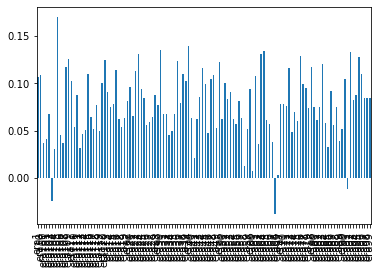

autocorrelation
0.09599977729782118
mean correlation
0.07665868434942874
sharpe
2.18320775495133
smart sharpe
1.976095406935685

Iteration 12:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.10771971298734744
0.08279832837415196
0.07726120581387395
0.14048254298249158
0.1242588195959636
0.09577434216628182
0.0788950210499631
0.12064211793637451
0.05457243739421721
0.10916335257981233
0.10400188916961108
0.10036053082700175
0.09497276826485802
0.07879191992167635
0.07837599016595725
0.11516409151061655
0.0663396003217574
0.05423611508803423
0.06535087081502533
0.09993131737701401
0.06838961257816555
0.11581586875160658
0.13275252628225523
0.09714047723958928
0.08592352575546282
0.05766269836257126
0.06022444231655931
0.06610229688694533
0.08851406788477881
0.13536699889175882
0.07128329332960143
0.06920879007156733
0.04659739859850449
0.050910117993865564
0.06871008198231357
0.1258473726167657
0.08191439230856004
0.11171673744217522
0.10583567986508348
0.06496200085681166
0.02424928560839088
0.06453351531968674
0.08659539203613272
0.1185081042310231
0.09826612654017348
0.04919052032443167
0.1070097105409622
0.1112136544147485
0.05522729905881971
0.0

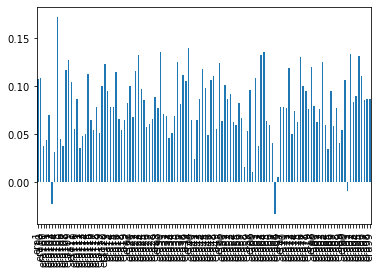

autocorrelation
0.09576264559805268
mean correlation
0.07849969523213945
sharpe
2.247058318681249
smart sharpe
2.0343714117482663

Iteration 13:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.1093355421074692
0.08329353620143062
0.07729411942112685
0.1411058715623133
0.12640954136896437
0.09719410647452814
0.07939724170801483
0.12210654527160379
0.05704947556831023
0.10897592429544015
0.10502129794748409
0.09905609218483155
0.09617263586444603
0.07980624916518016
0.07906925193310516
0.11644174750684348
0.06909144736319896
0.057499532307699386
0.06488493939528864
0.1022013007635466
0.0684326469286005
0.1157101556576772
0.13567132970226714
0.09846503675013982
0.0883601597614048
0.059913996284595
0.06090523649399124
0.06521568298186305
0.08970873947171794
0.135876249498924
0.07214476848677744
0.07051766417358721
0.0471261688064592
0.052839094323358704
0.06875530641227766
0.1281031739784176
0.08360275605083008
0.11163621106331864
0.10650390895953295
0.0652159168639417
0.02516836477986351
0.06680100165546
0.08842223104116242
0.11958002595375528
0.09879840597711967
0.05001600954559219
0.10825257085359985
0.11127821907788352
0.05761253250253012
0.067033495

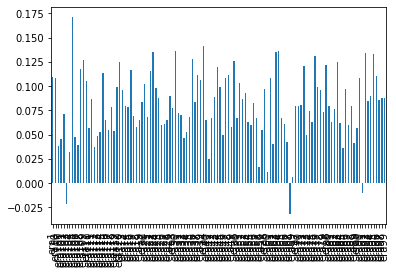

autocorrelation
0.0937323246192141
mean correlation
0.07950560840340476
sharpe
2.285049687127132
smart sharpe
2.072973413539443

Iteration 14:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.11178935500159416
0.0840085998453179
0.07759081060847249
0.14043852690737188
0.12779800289099746
0.09833619345336309
0.08143658889567541
0.12201548848052458
0.05840382974397146
0.10992427917929415
0.10547399243619271
0.0998151471730206
0.09678068563390818
0.08020146312879368
0.07994213248735796
0.11617592504412959
0.07159545159641867
0.06042363628038061
0.06551536322075964
0.102290906870773
0.0694232153763321
0.11551209692200248
0.13703212496623765
0.09950572606024882
0.08983774876082927
0.06181540498179095
0.06411088702666315
0.06490940932783647
0.09099034873771078
0.13639617838078613
0.07384158610975901
0.07181648998897844
0.047174434357717746
0.0540751474099177
0.07129059404530527
0.12900753159293396
0.08479191011259249
0.11287052677481621
0.10564114124522847
0.06693481620222777
0.025637157074666846
0.06855074629233356
0.08983628369346257
0.12108010154102593
0.09813741404730067
0.0508380775717654
0.1089365996923649
0.11392902170110944
0.058983352400207086
0.

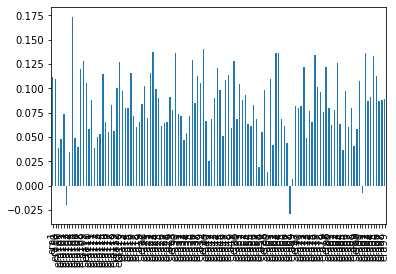

autocorrelation
0.0910989127217445
mean correlation
0.08062671219590963
sharpe
2.324904254618343
smart sharpe
2.1146908769560366

Iteration 15:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.11510490460550464
0.08504840197736802
0.08116922773933179
0.1387254193490251
0.12947805625278602
0.09956644300426894
0.08212659406873368
0.12261237621617765
0.06071979053636834
0.11052144090096347
0.10792667591942481
0.10223484158795768
0.09952934322116698
0.08267882952684343
0.08186973585580459
0.11769143564232064
0.07317147729976245
0.06286448600850636
0.06703215995003997
0.10439087470417645
0.06995294764595181
0.11536241301591468
0.1385157020482951
0.1021705836335352
0.09265085710071315
0.06294172149788602
0.06667340627966686
0.06529522166227035
0.09189243986467766
0.13790091839317614
0.07540674181859329
0.07308988397276905
0.04967290595252444
0.054901398628061884
0.07298298362710769
0.12939072700606014
0.08699375225449678
0.11412333153356441
0.1051155270520891
0.06832379038184007
0.028636293633735047
0.07168971928303328
0.09221430731426668
0.12245216398255264
0.09868788073697886
0.0521169723288427
0.10953878227862873
0.11566317367303316
0.061614048524964105

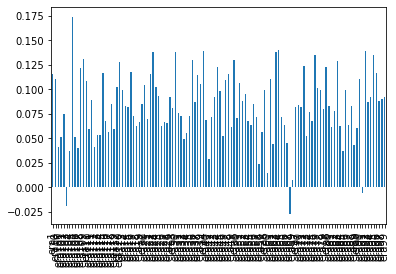

autocorrelation
0.09262722090188891
mean correlation
0.08237440258360855
sharpe
2.3825033722441695
smart sharpe
2.1637727177113932

Iteration 16:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.11645461886265387
0.08789703839100635
0.08234221892966853
0.13902741734842708
0.12934393909484662
0.10064328645358325
0.08249018124466437
0.12430040412810946
0.06149568337047302
0.11147921378216392
0.10821638081735153
0.1027005645180815
0.10154539861005288
0.08386115668707012
0.08338069822222341
0.11950998945124364
0.0743141018190788
0.06483655823574089
0.06955253065299653
0.10614957855014524
0.07198320306279704
0.11651802044326418
0.14053306016900796
0.10332641494940636
0.09266261047269445
0.06377826111410746
0.06929137957698699
0.06627096240392176
0.09425213737922096
0.13960570505853956
0.07827578234545646
0.07447053346676867
0.05085596931266663
0.05541251066993882
0.07273189430362373
0.13175016572551482
0.08737119928841351
0.1154947535105751
0.10604917857125107
0.06947441593438261
0.030192513267221697
0.07308304877340649
0.09309372243314845
0.12428996974600834
0.10039093600848178
0.054000766233036554
0.10863513318184491
0.11650077093201114
0.0630247840655652

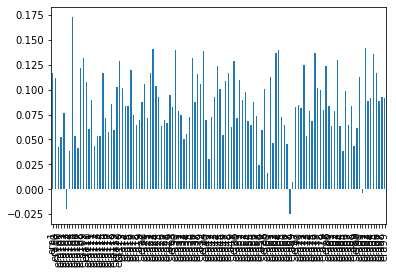

autocorrelation
0.09090921872788146
mean correlation
0.08356276129124868
sharpe
2.4243089070989066
smart sharpe
2.205525801047907

Iteration 17:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.1168835358237975
0.08775215451037874
0.08358783456798655
0.14149492231116126
0.12952782893410958
0.1032638247732164
0.08392794182522323
0.1221525824001741
0.06143041018507788
0.113976605499068
0.10989218502765637
0.10421033482683487
0.10283009415034394
0.08546893653938087
0.08478012545136829
0.1202696519092257
0.07569587120853452
0.06780009893633165
0.0707486919177054
0.10666646188965025
0.07242347830575481
0.11861124662852321
0.1422594082862318
0.10428853960195096
0.09431930375922044
0.06339470826383842
0.07127264825203623
0.06727192251707281
0.09548714501560425
0.14105104381677336
0.07858664543242869
0.0755093551623359
0.05121663788007644
0.05732566904040862
0.07352106024032945
0.13428578429391047
0.0895484317867928
0.1171241467650544
0.106153489325489
0.07135439311133829
0.03166971766030043
0.0754415790512859
0.09390456889870052
0.12637675878939522
0.09995128752824849
0.05485964762802057
0.1091965315296564
0.11754877349682957
0.06485821195919132
0.0747383024

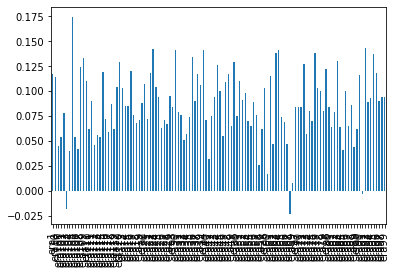

autocorrelation
0.08573862770569975
mean correlation
0.08477680445268018
sharpe
2.4586932584054093
smart sharpe
2.248394792073379

Iteration 18:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.11828774943911903
0.08998064933526606
0.08281132253516424
0.1396380015482419
0.12915096584080482
0.10345887850770348
0.08561805610730855
0.12102435103413844
0.06259388323287007
0.11508812275192516
0.11133842390258893
0.10561639232832878
0.10415674606557743
0.08686116048546785
0.08820920103622022
0.121245140728062
0.07611490435189154
0.0695346763463252
0.07196581700164953
0.10690194651043998
0.07239206607408613
0.11913312438595088
0.14416975951986952
0.10570185594771297
0.09578944707008753
0.0646454991613543
0.0735875740297949
0.06749536430554404
0.09546715419692574
0.14202481243865617
0.0807926827884031
0.07494269818348721
0.05109157713728319
0.05768240830206092
0.07412310224405423
0.13418143718058845
0.09072140006715235
0.11779634516412908
0.10757149587289777
0.07339946786803253
0.03294138354035877
0.07569674785976771
0.09567881402657667
0.129414336055603
0.10062948598354879
0.05739991724970231
0.1107480041128592
0.1190795796691677
0.0676961985709028
0.0765178

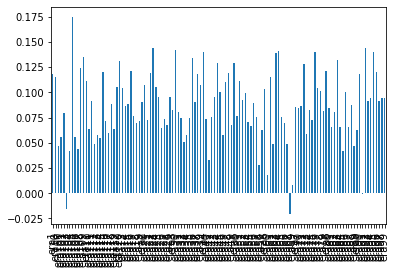

autocorrelation
0.09138004208981002
mean correlation
0.08604193201755161
sharpe
2.5120315676903755
smart sharpe
2.2842563406258964

Iteration 19:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.12174591264340191
0.08994163827192218
0.08210307794385106
0.14130293011321043
0.13049119776681456
0.10415492273949342
0.08668417538395853
0.12309563645069149
0.06360071762934338
0.1157487615803446
0.11230597537706676
0.10716342082915287
0.10475405674120634
0.08717002935778168
0.08905748670770335
0.1230057475392504
0.07747937539261382
0.07098235984130936
0.07280687501578215
0.10852751303964327
0.07395972166563285
0.12093086216649197
0.14459226137972483
0.10608035081144687
0.09607873357629079
0.06612803521337508
0.07480287260739961
0.0686423351929087
0.09484434812856204
0.14327369180673688
0.08207900652775031
0.074591368632529
0.05211622201369705
0.05937118554131629
0.07383938303419184
0.13474052331723047
0.09110901624375001
0.11906070465859171
0.10704079733094088
0.07510805973744253
0.0347292552567722
0.07732380411087773
0.09766896260901878
0.1317608365127498
0.10133570635251579
0.05801344459050853
0.1102703406446588
0.12045219756808369
0.06969581630926508
0.077

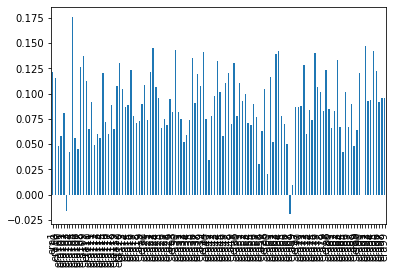

autocorrelation
0.08736767661066665
mean correlation
0.08712075642177679
sharpe
2.5448138338746844
smart sharpe
2.3233650320241326

Iteration 20:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.12267363094302192
0.09059801224724089
0.08385148870042934
0.14082950552728127
0.13207029840493534
0.10611495727677
0.08637579642940417
0.12236333600690116
0.06378729489700906
0.1169169695297401
0.11431760718979883
0.10899156355156245
0.10707852564828947
0.08966521417011897
0.0907353316509289
0.12273616390354646
0.07852790475585966
0.07335556781573349
0.07317305747402858
0.1095865646319853
0.07469294504498027
0.1226147382753188
0.14420467534977482
0.10887540055536589
0.09692421297499353
0.06693540656487333
0.07458796165883505
0.07016276459675208
0.0964488337588181
0.14421825786784176
0.0832891361448333
0.07596569501995439
0.05490840078520414
0.06019962001830181
0.07485916652183772
0.1344876184344669
0.0916295403429195
0.12117162982618061
0.10730277224042215
0.07583377268715093
0.037430232144475085
0.07878433236149526
0.0993715183086439
0.13277562407729185
0.10146580842620538
0.05875166702993372
0.11112713076780119
0.1212118049749055
0.07110784722730476
0.0783273

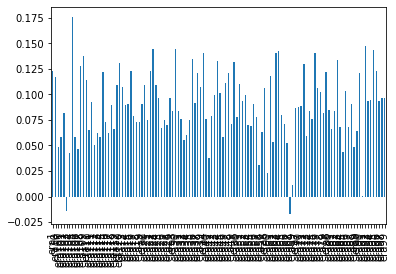

autocorrelation
0.08894317618753267
mean correlation
0.088126885698438
sharpe
2.589790629663178
smart sharpe
2.3607083826237267

Iteration 21:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.12427571674296316
0.09187781198040923
0.08306177630952037
0.13969056796520257
0.13206974469994184
0.10669667283584966
0.08936872472223169
0.12354122691753165
0.06665420446581913
0.11941313244235759
0.1149027595793514
0.1099873185239394
0.10864897430643408
0.09056345910826906
0.09123948770626678
0.1239593895109724
0.08024573877753728
0.07461425925246094
0.07253793421978727
0.11087984311041398
0.07573456416755273
0.12405199769649868
0.14439695047789922
0.11127299519034987
0.09999418605717754
0.06910953604555158
0.0749304986156198
0.07061396899950288
0.09571164014436452
0.14586914896949252
0.08448117499428802
0.07701182806296876
0.055618226885194584
0.0590132325709328
0.07646455542371927
0.13533245008916422
0.09330934188787827
0.1216648351072663
0.1070519463332738
0.07693441498477915
0.039894752207526106
0.08086804490738937
0.10144829050528545
0.13333201766516156
0.10417414306949915
0.06048940155477072
0.1125351713081312
0.12109928989977012
0.07328831583168299
0.0

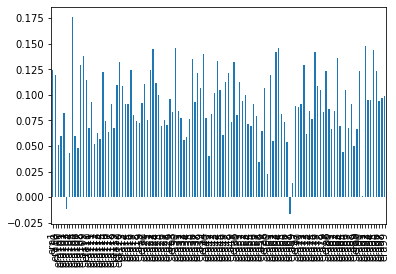

autocorrelation
0.08988391583228973
mean correlation
0.08923669055873609
sharpe
2.6312512805423642
smart sharpe
2.3962473933312816

Iteration 22:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.12553029023612045
0.09474213877917521
0.08458022808547888
0.1388640872877692
0.13100567279968994
0.1064877254683108
0.09016037309275415
0.1251410546176687
0.06857753168308543
0.12114122766625625
0.11668860675989677
0.11003212841911668
0.10900013360384755
0.09215135906840675
0.0922891500466586
0.12435069480000854
0.08212647697031722
0.07626902994596527
0.07459192279831413
0.11340228067673272
0.07694471459187004
0.12598972296295297
0.14567962173019433
0.11185450362948189
0.10004876258481983
0.0712658213576925
0.07739215199955035
0.07113922719866711
0.09616973643960479
0.147073835356586
0.08616665228691181
0.07952501558705877
0.05637136132617727
0.06191578084830761
0.07874524629965036
0.1367810495303263
0.09523275030207173
0.12290716139543041
0.10715717506973947
0.0762360383322372
0.04217275348997476
0.08271449993905973
0.10337815074465653
0.1339257811375847
0.1050965617413929
0.06371962150220997
0.11266269975356079
0.12227877548746362
0.07602375562832484
0.083213

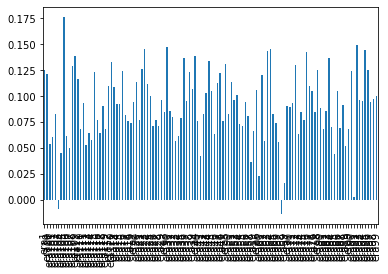

autocorrelation
0.0914841319436253
mean correlation
0.09059724067533809
sharpe
2.699794856895679
smart sharpe
2.4547389414341882

Iteration 23:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.1275021965984887
0.09471377998170193
0.0844742785035638
0.13838306802175152
0.13221526550161056
0.10719521160926868
0.09194485166728505
0.12522119116632482
0.07036682804071004
0.12214228009179255
0.11866971009255163
0.11133567709786103
0.10866653817675201
0.09280778892228773
0.09368787415670231
0.12587170909577428
0.08367956035422527
0.0762818084473955
0.07630276426357786
0.11459673904749018
0.07762857963120101
0.12623791210566693
0.14697672998150776
0.11310727994375971
0.1004202217474603
0.07158532806191392
0.0797570956404671
0.07241050596157571
0.09542341993387503
0.1468902942796963
0.08567355137378958
0.07995324566032384
0.057456651600502194
0.06299750158919691
0.07958787740835979
0.13776146225396887
0.09692113664568652
0.12277418571516585
0.10749705206500365
0.0782882982447666
0.04390558456693726
0.08445442599597204
0.10512454601145713
0.1348604541503694
0.10680518047971563
0.06489707796458977
0.11384140603891879
0.12229126969316477
0.07803916394672307
0.08

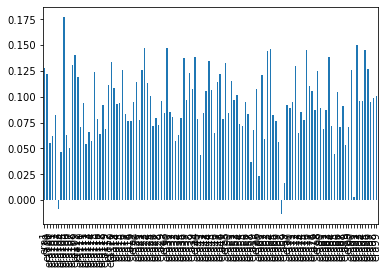

autocorrelation
0.09471069079260752
mean correlation
0.0914605370779014
sharpe
2.7246507014255017
smart sharpe
2.4693568527139362

Iteration 24:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.13042307589869612
0.09625565584075632
0.08527018099950022
0.13833092929586693
0.13292318329315153
0.10878340781823195
0.0932149347782238
0.12489934323734739
0.07049383609232654
0.12252200120245996
0.11984011323827339
0.11215907988348468
0.11104161774886544
0.09367344455174428
0.09516856959636781
0.12773043055069833
0.08400235841350083
0.07796833977834651
0.0759942110684831
0.11387292297394339
0.08051931141193278
0.1262768609748112
0.1473061571541311
0.1140197756690503
0.10127904176271738
0.07281658747295615
0.08201434716673667
0.07330469108765447
0.0965082271642873
0.14693876713260778
0.08591199557824088
0.07915605488852706
0.05893342570873409
0.06432906924411584
0.08021278237817966
0.13774876471065933
0.0974287553693787
0.12397117346626337
0.10720748360832974
0.07890494561056426
0.045313946973573986
0.08475810858512693
0.10670179335167829
0.13751288825585214
0.10719975171384791
0.06667963648980581
0.11477214217822818
0.12276882503774
0.079473255986799
0.085273

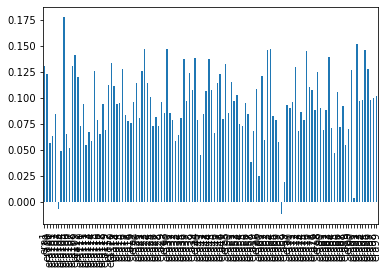

autocorrelation
0.09338012323278845
mean correlation
0.092524956506301
sharpe
2.7753586374493464
smart sharpe
2.518663768221409

Iteration 25:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.13222918911933734
0.09605358599899606
0.08605090147434076
0.14071997946249834
0.13241529904430793
0.10999842585082882
0.09323731374530128
0.1266796568287247
0.07051431094975476
0.12384404302030992
0.12012828157620853
0.11216655590365324
0.11225764505366889
0.09519755911377467
0.09633389823416423
0.1285667428926785
0.0863140697431382
0.0802752927562504
0.07717055132260306
0.11510557409529501
0.08162958779846828
0.1271291576661877
0.14967976193008048
0.11503862870984587
0.10410436815620082
0.07253659071475234
0.08311551775495576
0.07400077957632141
0.09792370030302984
0.14858467487472948
0.0868430132416977
0.07941319839446642
0.060935503440174316
0.06540298323200343
0.08164747239985574
0.1397571317393764
0.0986329264382237
0.12520861711257128
0.10910741097590503
0.08131756774404668
0.047112604686787046
0.08543111677038433
0.10831758419038037
0.13733643223432085
0.10838636675040118
0.0688390652354613
0.11481787783116648
0.12310841230196758
0.08156191145876353
0.08

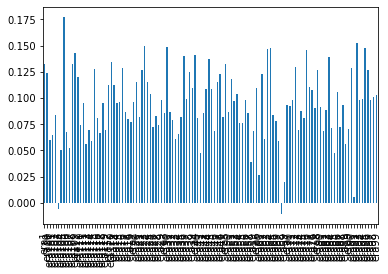

autocorrelation
0.09804286708409334
mean correlation
0.0936574836011841
sharpe
2.815339792147385
smart sharpe
2.5430537894469114

Iteration 26:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.13241629922752662
0.09797995145170531
0.08836782767015117
0.1403635648787379
0.13389407945794068
0.11080301562324231
0.09574297320139365
0.12759804004496167
0.07283064798558257
0.12513363657994067
0.1212109524979911
0.11326538602658218
0.11279880222207275
0.09447440315707994
0.098471577764691
0.1294604042428168
0.08621577432638419
0.0820306470046077
0.07827559466583474
0.116618489694591
0.08261052675946307
0.12759359624976643
0.14910611166238458
0.11721455683672631
0.10402054196600498
0.07338735473213345
0.08463572490544677
0.0755060467152949
0.09777517096717354
0.15000166458067418
0.08687498132500479
0.07922564222527193
0.06299857289651442
0.06539198923369985
0.08250347156010009
0.1394894027441469
0.10064682746294688
0.12602361805534243
0.10826214088737351
0.08255101828342402
0.04797307029548435
0.08662147201170238
0.11144981738466105
0.13806168093874133
0.11094383628851126
0.06892286778925463
0.11534475073146605
0.12373026672137241
0.08344580167989471
0.08689

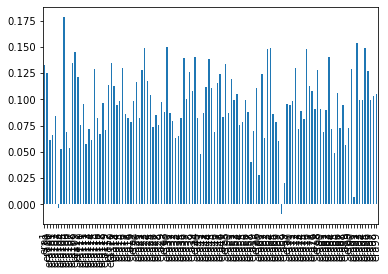

autocorrelation
0.09809789818097452
mean correlation
0.0947379734666179
sharpe
2.8551157533294433
smart sharpe
2.578840733484107

Iteration 27:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.1350441717046398
0.09758049904057123
0.08838505220922337
0.13797566874077094
0.13450712947314417
0.11326919915268358
0.09705381835936702
0.12739279259573585
0.07457437972798375
0.12666536306142828
0.12176405348400572
0.11338712104760039
0.11352130905574047
0.09607893984869822
0.09966613799211665
0.13200890093137427
0.08754140797804688
0.08253353126725373
0.08104297541885976
0.11935896343816174
0.08359971404504266
0.1276591117267158
0.1507446464329189
0.11956255990609951
0.10593509986268046
0.07507809499996347
0.08550104231244653
0.07507910487258578
0.0998191130650202
0.1512140563936635
0.08787140710519292
0.08058688827404396
0.0632384019174962
0.0661266976821733
0.08427743384666546
0.1412050492160723
0.10198251183987468
0.1279510177048425
0.1089611012654617
0.08342660955006377
0.04907937483163842
0.08734786932459485
0.11144752350047174
0.139051843408733
0.11183245360709683
0.07142567266379317
0.11645557560250713
0.12245974131697841
0.08423762631467183
0.0876343

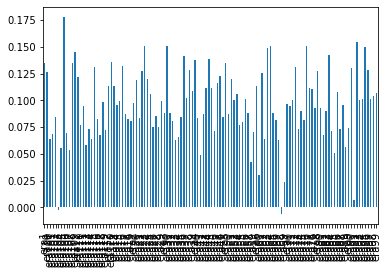

autocorrelation
0.09331774747113455
mean correlation
0.09592259634301617
sharpe
2.906939412171
smart sharpe
2.6382391383976005

Iteration 28:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.13635694390699224
0.09775635010503116
0.08900209577870208
0.13905851296423555
0.13512735548489904
0.1133102132546032
0.09754204310087405
0.12808792455419024
0.0759215579518012
0.12646197969520367
0.122496946614184
0.11395224641158774
0.11461903809362937
0.09654205954571747
0.09966942377517742
0.1325509992152313
0.0887956893940739
0.08328880182260442
0.08237894536798485
0.12060120174222998
0.08285745907145733
0.12917474401571477
0.151330558450679
0.12122048153490499
0.10725879899683673
0.07601069585574563
0.08656212324915324
0.07693215263631667
0.09962957954895056
0.15234849574817008
0.08759062480444108
0.0807352444075855
0.06357911062993254
0.06667807396110105
0.08590613635792052
0.1418535761627034
0.10276709260918566
0.12841246098444267
0.11039360032537496
0.08387535379275732
0.04966156099469906
0.08762869727601402
0.11262687565337502
0.13972577111491583
0.1129778127122265
0.07280681781191936
0.11644065709207047
0.12349817457765043
0.08667770681605454
0.088845

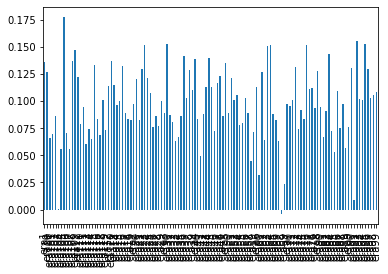

autocorrelation
0.09477572766394682
mean correlation
0.09693115998167727
sharpe
2.948272030028138
smart sharpe
2.6718514904567034

Iteration 29:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.1383263429621175
0.09890427415109303
0.08856414630495812
0.1389006410389711
0.1358104757590318
0.11469862567926764
0.09970564751152337
0.12950056289250955
0.07660304209073741
0.12709101952737414
0.12267132479247593
0.11411560471919692
0.11426007359161419
0.09757664358188478
0.09979960938169678
0.13272266571651517
0.09124691332508635
0.08448816484158357
0.08198104790653993
0.1211156847114022
0.08375104412994969
0.1292150833863277
0.15198424533179375
0.12209813180032487
0.10819067968919899
0.07813410127306901
0.08891009479218198
0.07706548754131025
0.09953228764447992
0.15280342848988007
0.08785788573050496
0.08230372115725133
0.0636154050100979
0.06709414788017364
0.087212300619137
0.14275141212245357
0.10341028876986465
0.12861301323051796
0.11081048438092692
0.08419341015811165
0.04986896950336578
0.08847901097729544
0.11490064805315574
0.14137745228298654
0.11345564162034937
0.07326061512991928
0.11706539078032756
0.12448381656265438
0.08693825938244153
0.089

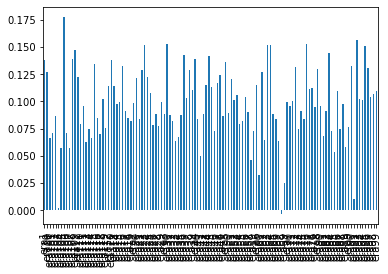

autocorrelation
0.0908708935292567
mean correlation
0.09770116125282503
sharpe
2.981404507542331
smart sharpe
2.712449928795544

Iteration 30:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.14021414137071705
0.1028842348458506
0.08995142669787999
0.14090811124300148
0.13720281599201198
0.11711073474612421
0.10064075856388204
0.13107980463483523
0.07864407256470561
0.12738253439998876
0.12328166954601241
0.11608373170773945
0.11611713854780746
0.09911305124521767
0.10064728672915481
0.13303932451984896
0.09300496675133443
0.08451307209730347
0.08556451620335558
0.12330564604678776
0.08353467498697544
0.13168123010620816
0.15498653540657462
0.12410552960609982
0.11000066494108389
0.07621882356582817
0.09146940537751364
0.08155399998218699
0.10023445846702132
0.15481138463219876
0.08981114909612627
0.08276874068435155
0.06315832436589443
0.06807291579416991
0.08778866117941728
0.1450386732898598
0.10484099098886025
0.1303286258648603
0.11122118129454288
0.08663201737927605
0.05285351225609789
0.09040194941420472
0.11706873361901037
0.14232477941441415
0.11611009127153403
0.07408248404187323
0.11971425199367187
0.12466392771560793
0.08945196845319205


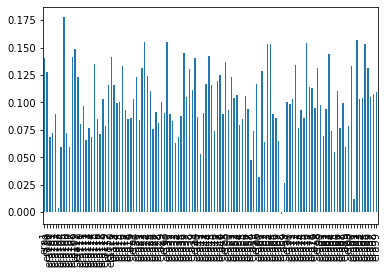

autocorrelation
0.09265345013836389
mean correlation
0.0992482932150527
sharpe
3.028498184167139
smart sharpe
2.7503884903499425

Iteration 31:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.14281456689659305
0.10396491452271761
0.09054986314770828
0.14163152884268748
0.1382709566870903
0.11832807572156206
0.10117511930018018
0.13221337944596456
0.07996740924924883
0.12741089803040964
0.12551976651803395
0.11482001474400175
0.11833478458100696
0.10137353976779354
0.10255200603519905
0.13318680675124084
0.09417569442475603
0.08634012492113043
0.0855021331488247
0.1255159623038621
0.08275311788006295
0.1330078023540398
0.1558235577986156
0.1265332533215454
0.11175231856647395
0.07707278240665448
0.09349719390204941
0.08392008098890334
0.10165509681015276
0.15566902970844415
0.09157787298354178
0.08421962307555536
0.06559058207951465
0.06908695517371667
0.08857058616073656
0.14709328747220116
0.10626923111104086
0.13360084393323426
0.11252780873907783
0.08864295898403743
0.054783303797535265
0.09254660284113825
0.1183917118459501
0.1459271949791792
0.11740076146879028
0.07684713332889531
0.12152581405322505
0.1252858180563153
0.09118919734505641
0.092

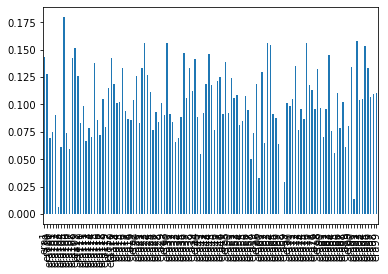

autocorrelation
0.09392192531028469
mean correlation
0.10064304806505235
sharpe
3.071966943689721
smart sharpe
2.786328095426753

Iteration 32:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.14276883752323188
0.10517401770894799
0.0901425648499397
0.14142452115790646
0.13882151670255582
0.11867416246501179
0.1014903708799007
0.13349849413065737
0.08117548633942501
0.12954113602026246
0.1248630664951525
0.11522992659507521
0.11959401936854086
0.1001973518536712
0.1048416040260347
0.13413771545355113
0.09532256020154371
0.0879758805408907
0.08638766511588353
0.1251996840825944
0.08320808124946696
0.1346285589318645
0.15634041930427928
0.12730732123094438
0.11274777027486016
0.07792267385685324
0.09486783331646305
0.08415088633268791
0.10269431492030036
0.15580180064372148
0.09195248737385854
0.08549828807078973
0.06676104929708766
0.06992384440565767
0.08819282009096995
0.14757522026666284
0.10791235116384981
0.13551129086894256
0.11213653838195228
0.0896734973333684
0.05640060517740573
0.09349638250811519
0.11823844011939078
0.1459144674960004
0.11873740495048862
0.077217133687782
0.12286632615530578
0.12690604535918223
0.09308384092474743
0.0934247

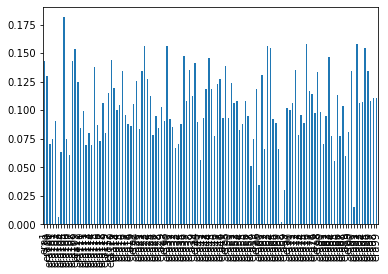

autocorrelation
0.09303158899716171
mean correlation
0.10148721767587547
sharpe
3.105005920491991
smart sharpe
2.8188042139961897

Iteration 33:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.14460098479673733
0.10568465361165617
0.08977871184975847
0.1424899453812518
0.13884810637241446
0.12274219158148195
0.102613340676372
0.1346381857620064
0.0811439868638292
0.13029633065417423
0.12629697941310156
0.11520295875432703
0.1222557861908626
0.10145270276580354
0.10569108257938493
0.13299984416377292
0.09552118438976581
0.08878197971788297
0.08739901573320061
0.12666513084563313
0.08428690430896665
0.13657629107483943
0.15650413376672978
0.1287100715989949
0.11449976521132246
0.07908213585947009
0.09458006079229343
0.08543751222972483
0.1043452430934
0.15611483022960682
0.09380910225146732
0.08554320479619903
0.06789736042555072
0.07116542509321962
0.08966739490298344
0.1484192113441124
0.10845300525754951
0.13738765778300527
0.11303632399346933
0.09004711683817264
0.0573833457597342
0.09492873985296418
0.11975362833564915
0.14767217916582864
0.12000323947378433
0.0775094477907841
0.12424318847967789
0.12839952545916078
0.0940719484252903
0.0939773361

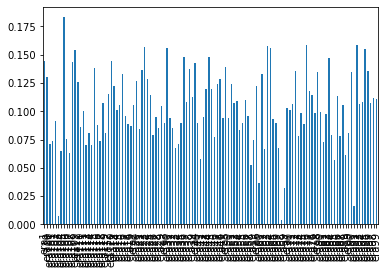

autocorrelation
0.08803092686274155
mean correlation
0.10255284597430406
sharpe
3.1396941495259476
smart sharpe
2.8645800105899926

Iteration 34:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.1471051107434889
0.10614024656761707
0.09060782907109133
0.14298417187600274
0.13925122650513921
0.12361611027467781
0.10435039015566479
0.13545004042973297
0.08190499538275008
0.13118015353090004
0.12592437283695107
0.11528146118037381
0.12346173543593449
0.10240926087204628
0.1061424837143834
0.13460963552739577
0.0972359768285897
0.08977442449992609
0.08815785470154237
0.12776753279717348
0.08631209780133842
0.13676374964611077
0.15757054010101648
0.13053260088381805
0.11501983642668757
0.08020881252595252
0.09551544467838233
0.08722568655118221
0.10479627681192658
0.15556612781720017
0.09644754876939912
0.08696234505395586
0.06973101653703292
0.07202650669252439
0.09058352637147471
0.14934023711711192
0.10941738991052202
0.13882333951805503
0.11341174005911275
0.09009453853966547
0.057933923793415415
0.09537267565692598
0.12181112036961247
0.14892009538180814
0.11944029412100278
0.07884783908055555
0.12449333524185116
0.12912909906796113
0.09501268788132458

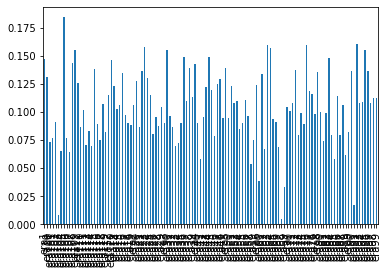

autocorrelation
0.08998891623046935
mean correlation
0.10348791182195481
sharpe
3.173781672662928
smart sharpe
2.8900196380210947

Iteration 35:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.14898839594007568
0.10567161156791678
0.09171554365662044
0.14405696128126647
0.14171133676311087
0.12516800028920574
0.10566067623407317
0.13618211654181592
0.08187647660280856
0.1320064467193075
0.12764095115316418
0.11707345750336874
0.1252090831985246
0.10324444679412575
0.10628778320998306
0.13437740080577712
0.0976043464727887
0.09146083781305196
0.08882715442344193
0.1284942453096099
0.08698096072661857
0.13766667336303748
0.15745013959324763
0.13023882363371336
0.11616088926278964
0.08043588087558955
0.09698115418188795
0.08874996071653143
0.10601172091546225
0.1557602712456096
0.09663916367535708
0.08701096530770157
0.07155147939403893
0.07395359673886705
0.09075862834119423
0.1503037654580483
0.11091187300919984
0.139565455762191
0.11407065417494677
0.09102977669905714
0.058013694527490216
0.09620658741970628
0.12354635383402941
0.14951183117223235
0.12008767395569298
0.07995366139265188
0.12547087558090328
0.1289455951796721
0.09690830659262767
0.095

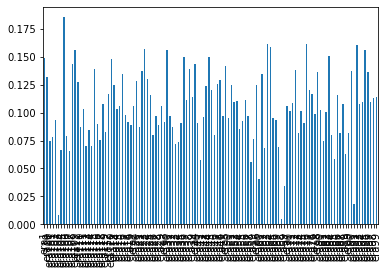

autocorrelation
0.08674515096232567
mean correlation
0.10448960206602159
sharpe
3.201630300752219
smart sharpe
2.9248441461247463

Iteration 36:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.14981342407908804
0.10756677549540676
0.09308553314647437
0.14374653591910547
0.14243935154647555
0.1257877158132226
0.10521853026557033
0.13657654773472258
0.08280060126331269
0.132603045781037
0.12744509439476304
0.11739942043655154
0.12676317730807662
0.10351308229074012
0.106309530365764
0.1353716551673953
0.09703485380027083
0.09133845582300419
0.0897319387701394
0.12939613095275643
0.08748018559299259
0.13840449637546365
0.1597565147838431
0.1313721303331382
0.11712553730185143
0.08052019169001029
0.09769987103308994
0.08938514000897692
0.10658694405306514
0.15629783760260643
0.09843444017111641
0.08767369972583244
0.0729488177674004
0.07560524910598046
0.09193975208911913
0.15100718452061437
0.1115139283532689
0.14017302063753118
0.11471792081760457
0.09135725766679523
0.05833238382973418
0.09530482087173169
0.12428889683738038
0.15050834775161404
0.1213184983468427
0.08075046121980504
0.12534595960998707
0.13020077547781517
0.09764880813092142
0.0966027

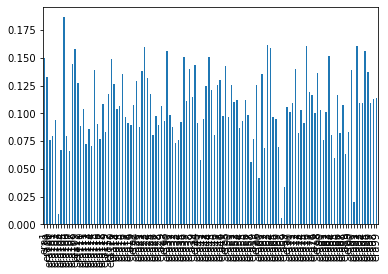

autocorrelation
0.08801055892914283
mean correlation
0.10517074682021511
sharpe
3.2279641950058853
smart sharpe
2.9451753797125106

Iteration 37:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.1514433276328333
0.10676311374058725
0.09370815393936574
0.14363724804177483
0.1424485355190531
0.1264519660518642
0.10646730497267824
0.13763442732432815
0.08316673273532468
0.13362083115573412
0.12853899953809106
0.11774927423597138
0.1263507594168919
0.10452874322039675
0.1073527715368492
0.13568128779715363
0.09921515099518227
0.09233429232408195
0.09013195068713532
0.13037731902474708
0.08765972644682869
0.13887657507521398
0.1602964318520297
0.13230770136828934
0.11704286546875028
0.08159323358236698
0.09886250272726115
0.09023414454746434
0.10531650216440852
0.15822259725222976
0.09886978784261209
0.08844008990301892
0.07380267591923546
0.07635531017913301
0.09356056114062071
0.15189245648544455
0.11316018376297109
0.14064910778509263
0.11544676876877474
0.09232698349865731
0.05922016089735615
0.09516922646457138
0.12666853694770341
0.1516010262287925
0.121748631204435
0.08169035298625496
0.12634808013507706
0.13087042720522743
0.09795637775111322
0.0966

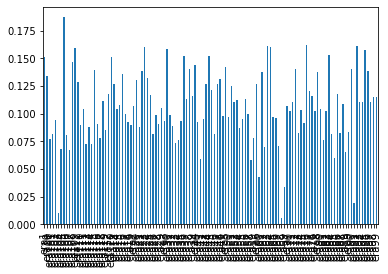

autocorrelation
0.08760048867008735
mean correlation
0.10602463442732732
sharpe
3.2516528820749753
smart sharpe
2.968004699649608

Iteration 38:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.15253549103827171
0.10750398148603017
0.09411868049567668
0.14389320301065203
0.14189055154446545
0.12847292703787913
0.10857222026688487
0.13791670617988078
0.08424902277143234
0.13316720940333202
0.12834980435767537
0.11849395101372436
0.1265391046409684
0.10668040676415104
0.10899002393613132
0.13688969297184428
0.1000681220246564
0.09354862962544744
0.09087113262042858
0.13122282719589506
0.08797587096178358
0.13874216886606117
0.16079663242541256
0.13292071977166192
0.11827111338251796
0.0830544432157269
0.10122355145369742
0.09186807435500562
0.10558506444797508
0.15937135719584666
0.10086467433252863
0.08857293141062497
0.07483538095215135
0.07567419203538195
0.09407509181760128
0.15329464302474302
0.11328870063220584
0.14041575583282132
0.11460043221320633
0.09274056419651164
0.05959876695425999
0.09674223230957714
0.1282025800614618
0.151322491444131
0.12268865798984614
0.08136963936506576
0.1262626552557471
0.13059578134042027
0.09882685137742483
0.09

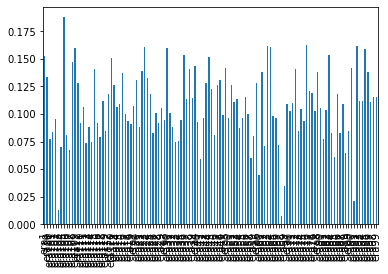

autocorrelation
0.08161132164528154
mean correlation
0.10690723967652786
sharpe
3.300124757748275
smart sharpe
3.0303194242116915

Iteration 39:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.15312788590933174
0.10829875456197821
0.09408195615551207
0.14537751698091453
0.1439591103230574
0.12895690266998183
0.1089238856972088
0.13918233430903548
0.08357228524096127
0.13423185220173275
0.12885075968050586
0.11849431601519925
0.12650884095509332
0.1083083903912092
0.11095093302333273
0.13660881849067383
0.10029362440317724
0.09478105991387177
0.09163992915776394
0.13034602148359248
0.08802648699243545
0.13974414315504238
0.1620919951370713
0.13269606591893635
0.11996842684801372
0.08414120910566424
0.10049200594023129
0.09260474767816862
0.10595261078522768
0.16034339776935982
0.10141837153665643
0.08917391393607729
0.07529244376854159
0.07519723723755077
0.09389680503093456
0.15396554513004707
0.1129714436767555
0.1420139794173221
0.11512709805851676
0.09334419762229622
0.05943119904266897
0.09827948750953991
0.1279041000894308
0.15176831643707325
0.12356365914808362
0.08299092601772261
0.12593685254859038
0.13156049590706081
0.09915635678787009
0.09

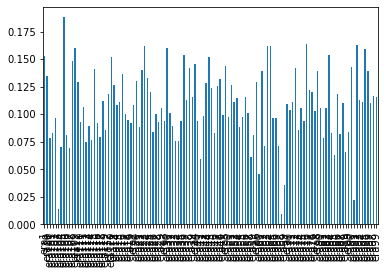

autocorrelation
0.08014498934513291
mean correlation
0.1075457891279984
sharpe
3.3232161292031774
smart sharpe
3.0559921348059698

Iteration 40:

fitting on worst eras
predicting on train


<ipython-input-9-1a800c11482c>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.1543368827460328
0.11159361006383829
0.09710030401829733
0.14730290503656268
0.14554747836821347
0.12960057523376484
0.1101301614377262
0.14169819853819982
0.08525463082560629
0.13452680759982305
0.13018522552058232
0.11866126981565063
0.12894757170706675
0.10934748137967863
0.1147947437908123
0.13626230379511253
0.10043050948546346
0.09680879218434238
0.09249698543121285
0.13162946786138308
0.08796307002503453
0.1403886025919191
0.16309401559921427
0.13380473691966233
0.12115002387466321
0.08520260593002273
0.1027977522296485
0.09505364491762218
0.10684101426537328
0.1610637666263503
0.10191319223788109
0.09146560503376917
0.07620972701095648
0.07533081141652054
0.09493225901079488
0.154270522450176
0.11440965924843562
0.14236269948169392
0.11749577207701616
0.09419447482905406
0.06044935081812612
0.09941994181961411
0.12909808168494957
0.15306455281741285
0.12567808126398924
0.08428860737352299
0.1267734530392786
0.13238472220083639
0.10066460831737478
0.0994

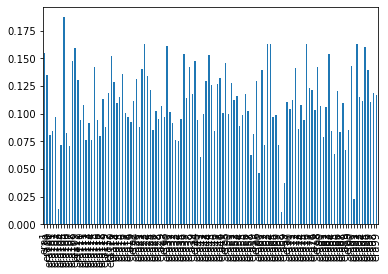

autocorrelation
0.08258985320655926
mean correlation
0.10866357229538555
sharpe
3.376977846420692
smart sharpe
3.0978617117325795


In [10]:
boost_model = era_boost_train(X_train, y_train,
                              era_col=train["era"], proportion=1.0,
                              trees_per_step=10, num_iters=40)

In [ ]:
boost_model5 = era_boost_train(X_train, y_train,
                              era_col=train["era"], proportion=0.5,
                              trees_per_step=10, num_iters=40)


#### Era boost train with proportion 1.000 ####

Testing model performance

Iteration 1:

predicting on train


<ipython-input-41-3195f6224908>:68: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.19474369044477086
0.18912299100748894
0.1867078123061707
0.1899751587204526
0.19111022662190755
0.18953431875382
0.18993729394022785
0.20165356774680598
0.17957040670327173
0.1847057120140987
0.18500187860336764
0.1889349181889671
0.1924616532160909
0.18822459572355577
0.18760263465000085
0.19887170024145867
0.18062755077410433
0.17991572836854258
0.186189846590258
0.19050076534300622
0.1858771045300026
0.19586977380130569
0.19467202911451714
0.18950868090413722
0.18809959331641818
0.18236329840433746
0.1810216381431195
0.19053099435677048
0.1812540985773957
0.1791743200251716
0.1869554820419506
0.17289265388540961
0.186303565522808
0.187622014363147
0.19150150734728597
0.18305270578735577
0.18957755458095799
0.19024670605737867
0.17981005127802394
0.18640627159071693
0.18826829939695727
0.18988814637824536
0.1867041973442968
0.1855354471069453
0.19114807886359864
0.1809423921869282
0.18752090033434898
0.18618606053717168
0.19396425577643622
0.17881779191570588

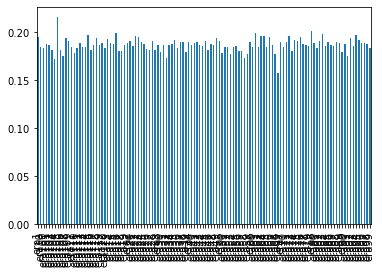

autocorrelation
-0.03672838343173593
mean correlation
0.1869056718183428
sharpe
27.18958972270288
smart sharpe
28.080870153284458

Iteration 2:

fitting on worst eras


In [ ]:
boost_model_half_and_half = era_boost_train(X_train, y_train,
                              era_col=train["era"], proportion=1,
                              trees_per_step=0, num_iters=5, test_model=boost_model_half_and_half)

In [ ]:
# with_val1 = era_boost_train(X_val1, y_val1,
#                                           era_col=train["era"], proportion=0.5,
#                                           trees_per_step=10, num_iters=40, test_model=boost_model_half_and_half)

In [9]:
save_model(boost_model, "burningcrusade.pkl")
with open('burningcrusade_features.pkl', 'wb') as f:
    pickle.dump(ft_corr_list, f)

In [ ]:
save_model(boost_model5, "burningcrusade5.pkl")

In [52]:
save_model(boost_model_half_and_half, "wotlk.pkl")

In [11]:
tournament_full = tournament_static.copy()
tournament_full.loc[:, PREDICTION_NAME] = boost_model.predict(X_tournament)
current_round = NAPI.get_current_round()
tournament_full.set_index('id', inplace=True)
tournament_full[PREDICTION_NAME].to_csv(f"../../submissions/combustion/submission_{current_round}.csv", header=True)

In [ ]:
tournament5 = tournament_static.copy()
tournament5.loc[:, PREDICTION_NAME] = boost_model5.predict(X_tournament)
current_round = NAPI.get_current_round()
tournament5.set_index('id', inplace=True)
tournament5[PREDICTION_NAME].to_csv(f"../../submissions/combustion/submission_{current_round}_half_boost.csv", header=True)

In [56]:
tournament_half = tournament_static.copy()
tournament_half.loc[:, PREDICTION_NAME] = boost_model_half_and_half.predict(X_tournament)
current_round = NAPI.get_current_round()
tournament_half.set_index('id', inplace=True)
tournament_half[PREDICTION_NAME].to_csv(f"../../submissions/combustion/submission_{current_round}_half_and_halfboost.csv", header=True)

In [ ]:
trees_strings = boost_model.get_booster().get_dump(dump_format='text')
total_splits = 0
for tree_string in trees_strings:
    n_nodes = len(tree_string.split('\n')) - 1
    n_leaves = tree_string.count('leaf')
    total_splits += n_nodes - n_leaves
print(total_splits)

In [ ]:
trees_strings = boost_model5.get_booster().get_dump(dump_format='text')
total_splits = 0
for tree_string in trees_strings:
    n_nodes = len(tree_string.split('\n')) - 1
    n_leaves = tree_string.count('leaf')
    total_splits += n_nodes - n_leaves
print(total_splits)

In [ ]:
val1 = ['era121', 'era122', 'era123', 'era124', 'era125', 'era126',
       'era127', 'era128', 'era129', 'era130', 'era131', 'era132',
       'era197', 'era198', 'era199']
val2 = ['era200', 'era201', 'era202',
       'era203', 'era204', 'era205', 'era206', 'era207', 'era208',
       'era209', 'era210', 'era211', 'era212']
val_set1 = tournament[tournament.era.isin(val1)]
val_set2 = tournament[tournament.era.isin(val2)]

In [ ]:
# get validation data
X_train, y_train = clean_for_xgboost(train)
dtrain = xgboost.DMatrix(X_train, y_train)

X_val1, y_val1 = clean_for_xgboost(val_set1)
dval1 = xgboost.DMatrix(X_val1, y_val1)

X_val2, y_val2 = clean_for_xgboost(val_set2)
dval2 = xgboost.DMatrix(X_val2, y_val2)

In [ ]:
def correlation_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'corr', np.corrcoef(labels, preds)[0,1]

In [ ]:
bst.best_score

In [ ]:
param = {
    'max_depth':5,
    'gamma': 0.2,
    'min_child_weight': 19,
    'eta':0.01,
    'objective':'reg:squarederror',
    'eval_metric':'rmse',
    'nthread': -1,
}
evals_result = {}
bst = xgboost.train(
    params=param,
    dtrain=dtrain,
    feval=correlation_score,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval1, 'val1'), (dval2, 'val2')],
    evals_result=evals_result,
    verbose_eval=10,
)

# (0.5 - 0.57*pandas.DataFrame({k: v['score'] for k,v in evals_result.items()})).plot()